# 2. Prétraitement des données

## Suppression des données inutiles

Comme déjà précisé auparavant, nous n'avons besoin que de la colonne `meantemp`. Nous pouvons donc déjà supprimer les autres colonnes. Le seul point à bien vérifier est que les données sont bien triées par date, mais c'est déjà le cas.


In [25]:
import pandas as pd

df = pd.read_csv("../data/GlobalDataSet.csv")

df_meantemp = df[["meantemp"]]

df_meantemp.to_csv("../data/GlobalDataSetClean.csv", index=False, header=False)

Nous avons donc maitenant un nouveau fichier comprenant uniquement la colonne `meantemp` : `data/GlobalDataSetClean.csv`

## Normalisation

Afin de permettre à notre modèle d'apprendre efficacement, il est nécessaire de normaliser les données.
En effet, des valeurs trop extrêmes pourraient influencer de manière disproportionnée l'apprentissage du modèle.
Nous avons donc choisi de normaliser les données selon un intervalle standard `[0;1]`.

### Type de normalisation

Deux façons de normaliser notre dataset s'offrent à nous :  
- Soit sous forme de fenêtre,
- Soit sur l’ensemble du dataset.

Après analyse, on se rend compte qu’il n’est pas pertinent de normaliser par fenêtre.  
En effet, cela reviendrait à placer sur la même échelle des séries comme `10, 20, 30` et `2, 4, 6`, qui deviendraient toutes deux `0, 0.5, 1`.  
Or, dans notre cas, nous cherchons à prédire une valeur réelle, et non une variation.

Nous devons donc appliquer une normalisation globale sur l’ensemble du dataset.


In [26]:
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv("../data/GlobalDataSetClean.csv", header=None)

scaler = MinMaxScaler()
normalized_values = scaler.fit_transform(df)

normalized_df = pd.DataFrame(normalized_values)

normalized_df.to_csv("../data/GlobalDataSetNormalized.csv", index=False, header=False)

Nous avons donc maitenant un autre fichier `data/GlobalDataSetNormalized` avec les données normalisées

## Fenêtrage

Une autre partie importante est de fenêtrer nos données. En effet, nous ne voulons pas que notre modèle prédise une valeur en fonction des quatre dernières années. Il est plus judicieux de choisir une taille de fenêtre plus courte.

Nous avons un peu de mal à décider de la taille de fenêtre idéale. Nos premières idées sont :

- 7 jours pour un suivi hebdomadaire,  
- 30 jours pour un suivi mensuel,  
- 14 jours comme compromis possible.

Après quelques recherches, nous allons essayer de calculer l’autocorrélation pour déterminer le choix le plus pertinent.




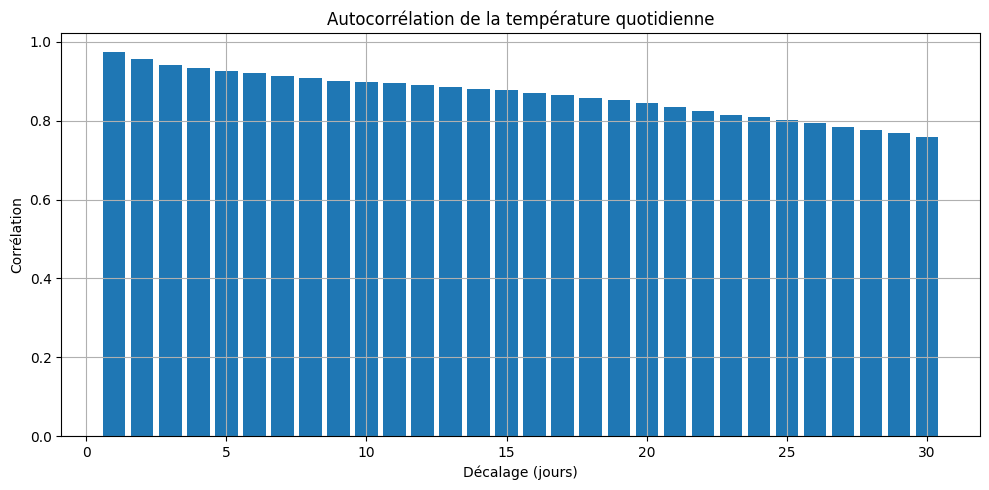

In [27]:
import matplotlib.pyplot as plt

df = pd.read_csv("../data/GlobalDataset.csv", parse_dates=['date'], index_col='date')


serie = df['meantemp']

max_lag = 30
autocorrs = [serie.autocorr(lag=lag) for lag in range(1, max_lag + 1)]

plt.figure(figsize=(10, 5))
plt.bar(range(1, max_lag + 1), autocorrs)
plt.title("Autocorrélation de la température quotidienne")
plt.xlabel("Décalage (jours)")
plt.ylabel("Corrélation")
plt.grid(True)
plt.tight_layout()
plt.show()

Nous y voyons un peu plus clair : on observe que les quelques jours précédents présentent une forte corrélation avec la température du jour. Cependant, la corrélation reste élevée même jusqu'à un mois de décalage.

Nous allons donc retenir une fenêtre de **14 jours**, qui nous semble être un bon compromis entre information et complexité du modèle.


### Création du dataset fenêtré

In [28]:

n = 14

X = []
y = []

for i in range(n, len(normalized_df)):
    window = normalized_df.iloc[i-n:i, 0].values  
    target = normalized_df.iloc[i, 0]
    X.append(window)
    y.append(target)

windowed_df = pd.DataFrame([list(x) + [y_val] for x, y_val in zip(X, y)], columns=columns)

windowed_df.to_csv("../data/GlobalDataSetWindowed.csv", index=False, header=False)

Un Fichier avec les données fenêtrée a été créé : `data/GlobalDataSetWindowed.csv`

## Préparation des différents dataset (Train, validation, test)

In [29]:
total_len = len(windowed_df)
train_size = int(0.7 * total_len)
val_size = int(0.15 * total_len)
test_size = total_len - train_size - val_size  # Assure que tout est utilisé

train_df = windowed_df.iloc[:train_size]
val_df = windowed_df.iloc[train_size:train_size + val_size]
test_df = windowed_df.iloc[train_size + val_size:]

train_df.to_csv("../data/TrainDataSet.csv", index=False, header=False)
val_df.to_csv("../data/ValidationDataSet.csv", index=False, header=False)
test_df.to_csv("../data/TestDataSet.csv", index=False, header=False)

Trois nouveaux fichiers ont été créés et représenteront les jeux de données finaux utilisés pour l'entraînement :

- `data/TrainDataSet.csv`
- `data/ValidationDataSet.csv`
- `data/TestDataSet.csv`

**Notebook suivant : Expérimentation et comparaison des architectures RNN**

👉 [Aller au Notebook suivant](03_experimentation_et_comparaison_architectures_rnn.ipynb)